In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
import torch
import torch.nn as nn

class GhostReLU(nn.Module):
    def __init__(self, a=1.735):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32))

    def forward(self, x):
        return x * torch.sigmoid(self.a * torch.tanh(x))

    def get_a(self):
        return self.a.item()

class Eclipse(nn.Module):
    def __init__(self, a=1.735):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32))

    def forward(self, x):
        gammoid = x / (1 + x.abs())
        return x * torch.sigmoid(self.a * gammoid)

    def get_a(self):
        return self.a.item()

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, activation=nn.ReLU):
        super(BasicBlock, self).__init__()
        self.activation = activation()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.activation(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, activation=nn.ReLU):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.activation = activation

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.activation))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.activation()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet20(activation):
    return ResNet(BasicBlock, [3, 3, 3], activation=activation)


In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100.0 * correct / total


def train_model(activation_cls, epochs=100, batch_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    model = ResNet20(activation_cls).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_accs, test_accs = [], []
    start_time = time.time()
    grad_norms = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        total_grad_norm = 0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            total_grad_norm += sum(p.grad.norm(2).item() for p in model.parameters() if p.grad is not None)
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        grad_norms.append(total_grad_norm / len(trainloader))
        train_acc = 100.0 * correct / total
        test_acc = evaluate(model, testloader, device)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, GradNorm: {grad_norms[-1]:.2f}")

    total_time = time.time() - start_time
    return {
        'model': model,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'grad_norms': grad_norms,
        'total_time': total_time
    }

Training Ghost ReLU
Epoch 1/100, Train Acc: 37.84%, Test Acc: 41.89%, GradNorm: 5.28
Epoch 2/100, Train Acc: 58.37%, Test Acc: 57.84%, GradNorm: 5.76
Epoch 3/100, Train Acc: 66.23%, Test Acc: 67.86%, GradNorm: 6.01
Epoch 4/100, Train Acc: 71.37%, Test Acc: 62.82%, GradNorm: 6.34
Epoch 5/100, Train Acc: 73.98%, Test Acc: 72.71%, GradNorm: 6.60
Epoch 6/100, Train Acc: 76.44%, Test Acc: 71.44%, GradNorm: 6.66
Epoch 7/100, Train Acc: 77.63%, Test Acc: 75.57%, GradNorm: 6.76
Epoch 8/100, Train Acc: 78.58%, Test Acc: 74.26%, GradNorm: 6.86
Epoch 9/100, Train Acc: 79.21%, Test Acc: 78.41%, GradNorm: 6.85
Epoch 10/100, Train Acc: 80.05%, Test Acc: 74.95%, GradNorm: 6.91
Epoch 11/100, Train Acc: 80.36%, Test Acc: 74.70%, GradNorm: 6.98
Epoch 12/100, Train Acc: 80.98%, Test Acc: 73.71%, GradNorm: 7.01
Epoch 13/100, Train Acc: 81.72%, Test Acc: 78.93%, GradNorm: 6.99
Epoch 14/100, Train Acc: 82.01%, Test Acc: 76.83%, GradNorm: 7.02
Epoch 15/100, Train Acc: 82.23%, Test Acc: 78.45%, GradNorm: 7.05

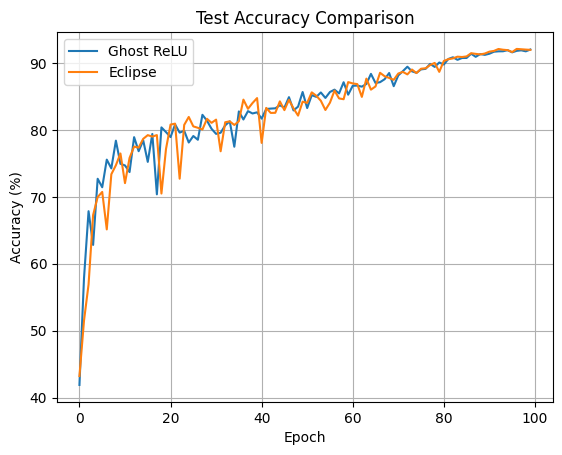

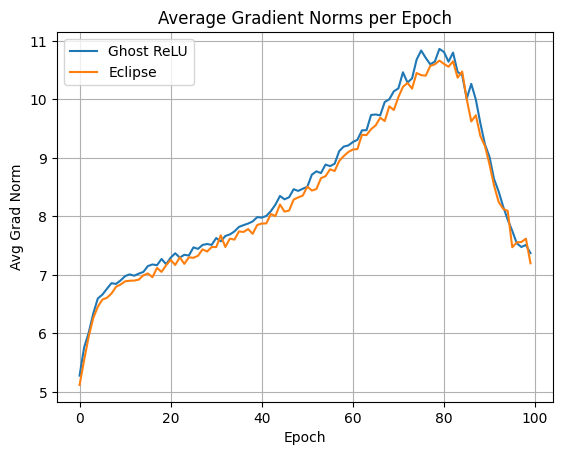

In [ ]:
if __name__ == '__main__':
    print("Training Ghost ReLU")
    result_ghost = train_model(GhostReLU)
    print("Training Eclipse")
    result_eclipse = train_model(Eclipse)

    print("\nTotal time (Ghost ReLU):", result_ghost['total_time'])
    print("Total time (Eclipse):", result_eclipse['total_time'])

    # Plotting Accuracy Comparison
    plt.plot(result_ghost['test_accs'], label='Ghost ReLU')
    plt.plot(result_eclipse['test_accs'], label='Eclipse')
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Gradient Norms
    plt.plot(result_ghost['grad_norms'], label='Ghost ReLU')
    plt.plot(result_eclipse['grad_norms'], label='Eclipse')
    plt.title('Average Gradient Norms per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Avg Grad Norm')
    plt.legend()
    plt.grid(True)
    plt.show()
